# Loading packages

In [20]:
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scib
import os
import random
seed = 42
def set_seed(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

from cell2location.utils.filtering import filter_genes

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/torchmetrics/utilities/imports.py:24: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _PYTHON_LOWER_3_8 = LooseVersion(_PYTHON_VERSION) < LooseVersion("3.8")
Global seed set to 0


# Spatial 

In [6]:
adata_vis = sc.read_h5ad("spatial_example.h5ad")

In [7]:
array1, array2 = np.hsplit(adata_vis.obsm['spatial'], 2)

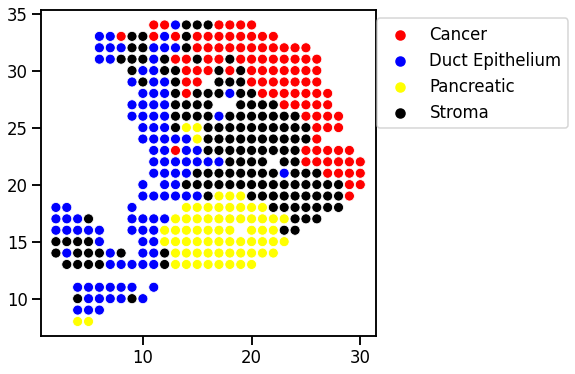

In [10]:
#visualize spatial dataset
plt.figure(figsize=(6, 6))
custom_palette = {'Cancer': 'red', 'Duct Epithelium': 'blue', 'Pancreatic': 'yellow', 'Stroma': 'black'}
sns.scatterplot(x=array1.flatten(), y=array2.flatten(), hue=adata_vis.obs['annotation'].astype('category'), palette=custom_palette, s=100)
plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1))
plt.show()

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


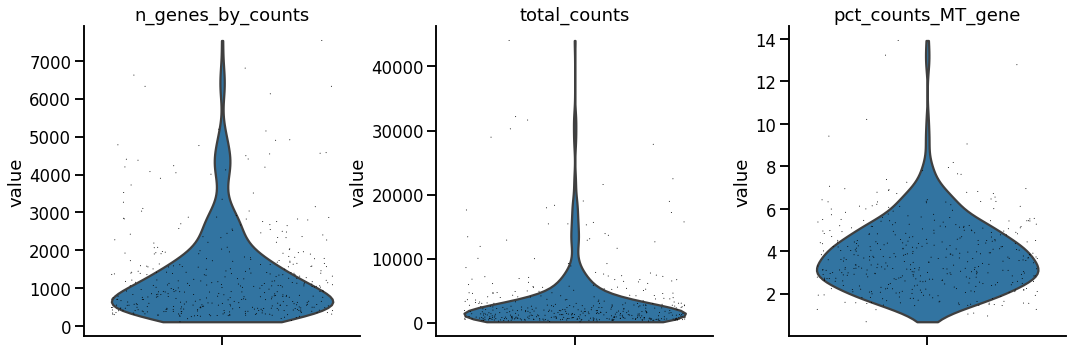

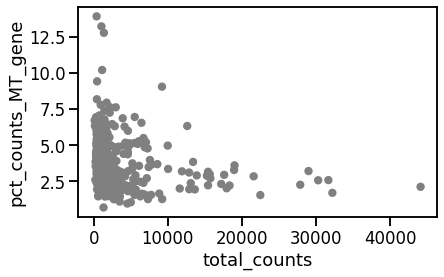

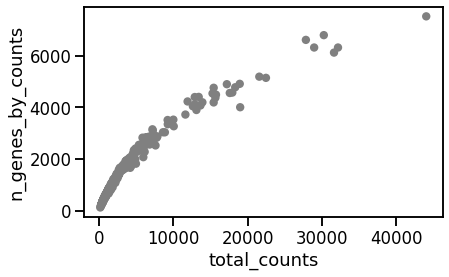

In [11]:
#remove mitochondria-encoded (MT) genes for spatial dataset
adata_vis.var_names[np.where([gene.startswith('MT.') for gene in adata_vis.var_names])[0].tolist()]
adata_vis.var['MT_gene'] = [gene.startswith('MT.') for gene in adata_vis.var_names]
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
sc.pp.calculate_qc_metrics(adata_vis, qc_vars=['MT_gene'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata_vis, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT_gene'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata_vis, x='total_counts', y='pct_counts_MT_gene')
sc.pl.scatter(adata_vis, x='total_counts', y='n_genes_by_counts')

adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

In [12]:
adata_vis.layers['raw'] = adata_vis.X.copy()

sc.pp.filter_cells(adata_vis, min_genes=10, inplace=True)
sc.pp.filter_genes(adata_vis, min_cells=2, inplace=True)

#It's important to keep the count information intact for following models.
adata_vis.layers['counts'] = adata_vis.X.copy()
adata_vis.layers['raw']
adata_vis

AnnData object with n_obs × n_vars = 428 × 17982
    obs: 'annotation', 'n_genes_by_counts', 'total_counts', 'total_counts_MT_gene', 'pct_counts_MT_gene', 'n_genes'
    var: 'MT_gene', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    obsm: 'spatial', 'MT'
    layers: 'raw', 'counts'

In [13]:
#Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization.
sc.pp.normalize_total(adata_vis)
#Logarithmize the data
sc.pp.log1p(adata_vis)

adata_vis.raw = adata_vis

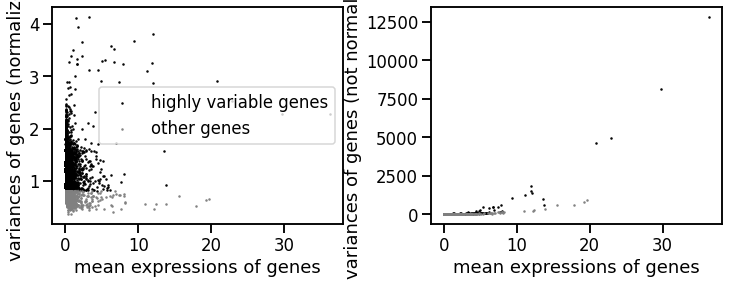

In [14]:
set_seed(seed)
sc.pp.highly_variable_genes(
    adata_vis,
    n_top_genes = 15000,
    layer = "counts",
    flavor = "seurat_v3",
    span = 1
)
sc.pl.highly_variable_genes(adata_vis)
adata_vis = adata_vis[:, adata_vis.var.highly_variable]

         Falling back to preprocessing with `sc.pp.pca` and default params.


/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#depre

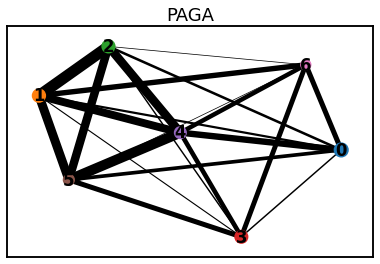

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


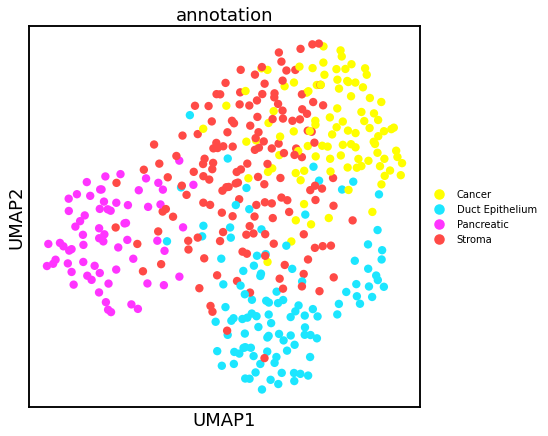

In [15]:
sc.pp.neighbors(adata_vis)
sc.tl.leiden(adata_vis)
sc.tl.paga(adata_vis, groups='leiden')
sc.pl.paga(adata_vis, title='PAGA')
sc.tl.umap(adata_vis, min_dist = 0.8, spread = 1.5, init_pos='paga')

with mpl.rc_context({'figure.figsize': [7, 7],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_vis, color=['annotation'], use_raw=False, title=["annotation"], 
               color_map = 'RdPu', wspace=0.4,
               legend_fontsize=10, palette=sc.pl.palettes.default_102)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


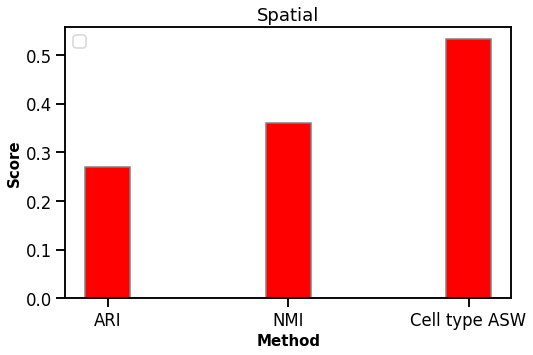

In [16]:
set_seed(seed)
sc.tl.leiden(adata_vis)

barWidth = 0.25
fig = plt.subplots(figsize =(8, 5))

#a. Adjusted Rand Index
aris_vis = scib.me.ari(adata_vis, cluster_key="leiden", label_key="annotation")

#b. Normalized mutual information
nmis_vis = scib.me.nmi(adata_vis, cluster_key="leiden", label_key="annotation")

#c. Average silhouette width (ASW)
asw_vis = scib.me.silhouette(adata_vis, label_key="annotation", embed="X_pca")

# Make the plot
plt.bar(["ARI", "NMI", "Cell type ASW"], [aris_vis, nmis_vis, asw_vis], color ='r', width = barWidth,
        edgecolor ='grey')

# Adding Xticks
plt.xlabel('Method', fontweight ='bold', fontsize = 15)
plt.ylabel('Score', fontweight ='bold', fontsize = 15)
plt.title('Spatial')

plt.legend()
plt.show()

# Single cell reference

In [17]:
adata_ref = sc.read_h5ad("reference_example.h5ad")
adata_ref

AnnData object with n_obs × n_vars = 1926 × 19736
    obs: 'celltype', 'Sample'

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


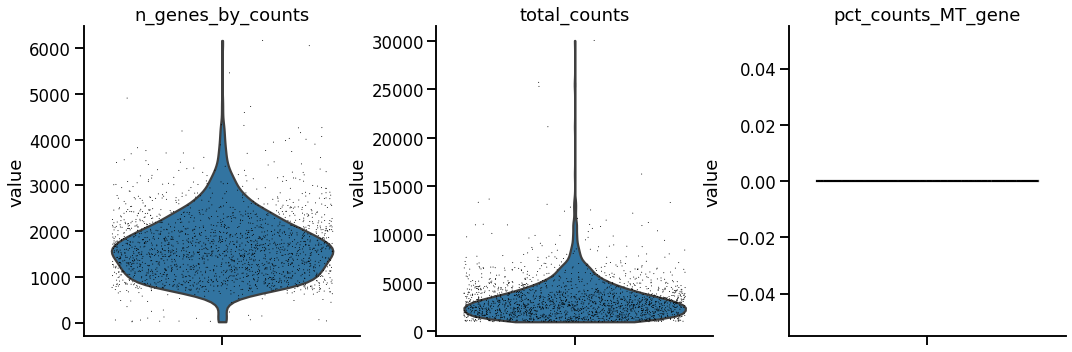

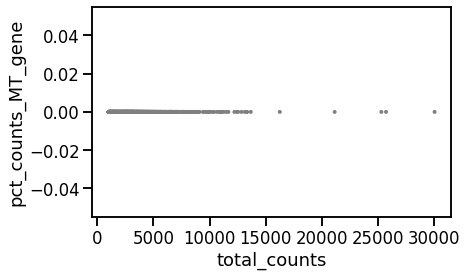

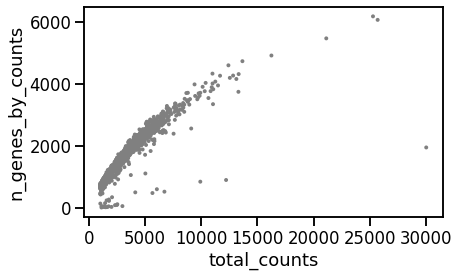

In [18]:
#remove mitochondria-encoded (MT) genes 
adata_ref.var_names[np.where([gene.startswith('MT.') for gene in adata_ref.var_names])[0].tolist()]
adata_ref.var['MT_gene'] = [gene.startswith('MT.') for gene in adata_ref.var_names]
adata_ref.obsm['MT'] = adata_ref[:, adata_ref.var['MT_gene'].values].X.toarray()
sc.pp.calculate_qc_metrics(adata_ref, qc_vars=['MT_gene'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata_ref, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT_gene'], jitter=0.4, multi_panel=True)
sc.pl.scatter(adata_ref, x='total_counts', y='pct_counts_MT_gene')
sc.pl.scatter(adata_ref, x='total_counts', y='n_genes_by_counts')

adata_ref = adata_ref[:, ~adata_ref.var['MT_gene'].values]

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


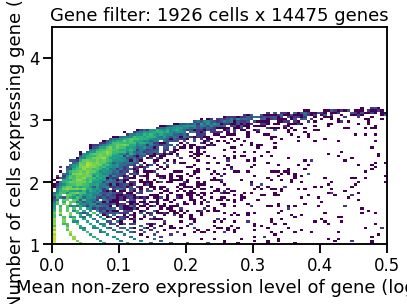

In [21]:
adata_ref.layers['raw'] = adata_ref.X.copy()

sc.pp.filter_cells(adata_ref, min_genes=1, inplace=True)

#Permissive gene selection not using standard highly variable gene selections to keep markers or rare genes while removing most uniformative genes.
selected = filter_genes(adata_ref, cell_count_cutoff=3, cell_percentage_cutoff2=0.02, nonz_mean_cutoff=0.5)
adata_ref = adata_ref[:, selected].copy()

#It's important to keep the count information intact for following models.
adata_ref.layers['counts'] = adata_ref.X.copy()

In [22]:
#Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization.
sc.pp.normalize_total(adata_ref)
#Logarithmize the data
sc.pp.log1p(adata_ref)

adata_ref.raw = adata_ref

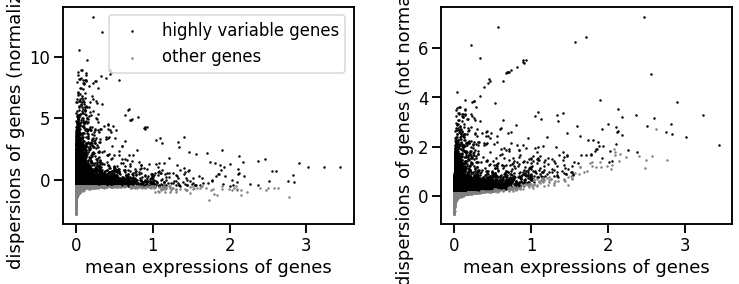

In [23]:
set_seed(seed)

sc.pp.highly_variable_genes(
    adata_ref,
    n_top_genes = 12000,
    #subset = True,
    #layer = "counts_scvi",
    #flavor = "seurat_v3",
    batch_key="Sample"
)

sc.pl.highly_variable_genes(adata_ref)
adata_ref = adata_ref[:, adata_ref.var.highly_variable]

         Falling back to preprocessing with `sc.pp.pca` and default params.


/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/networkx/convert.py:157: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  return nx.from_scipy_sparse_matrix(data, create_using=create_using)


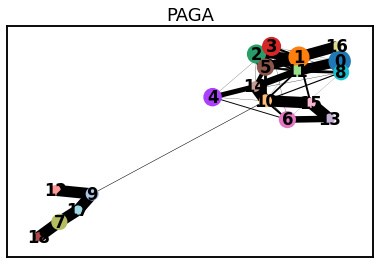

/mnt/md0/jin/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


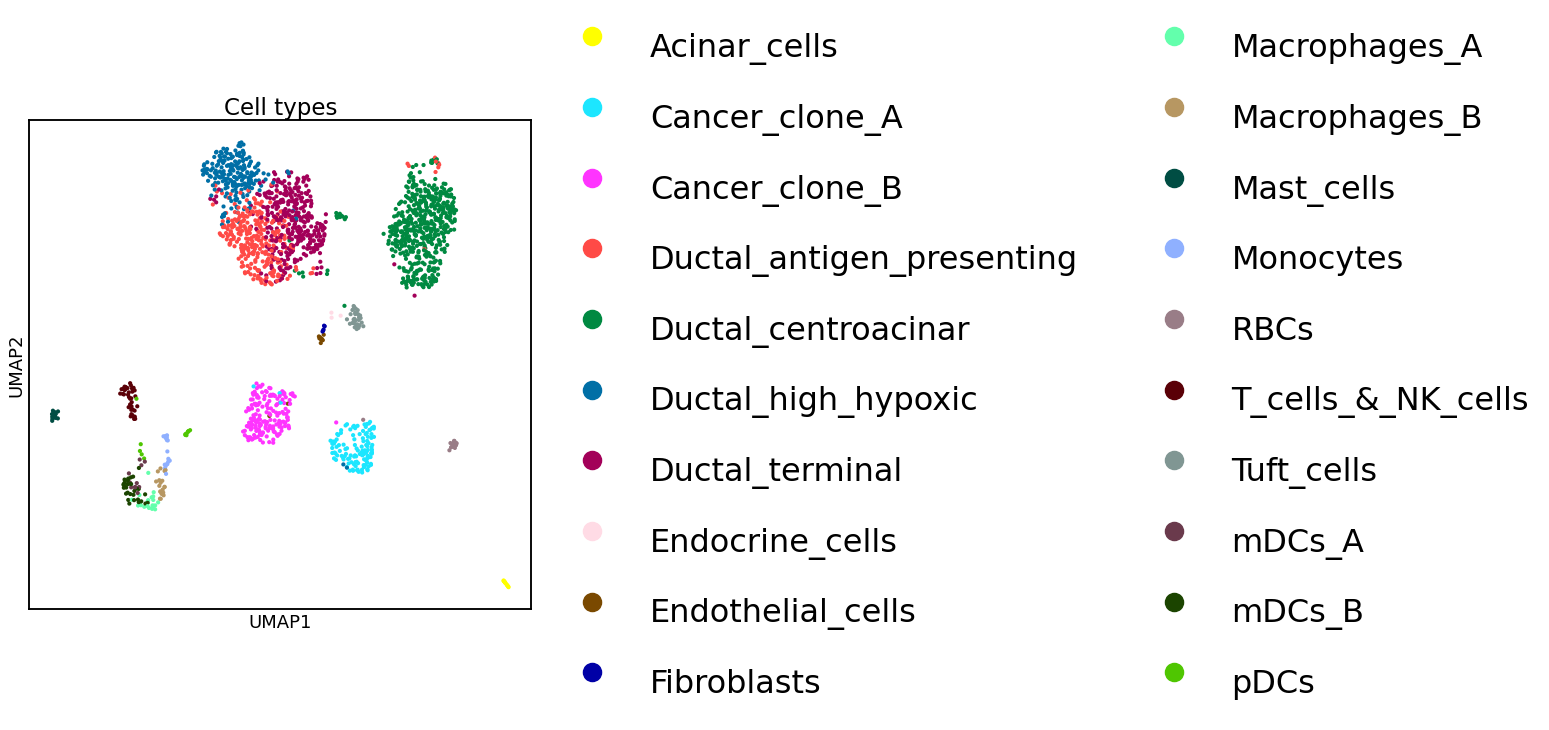

In [24]:
sc.pp.neighbors(adata_ref)
sc.tl.leiden(adata_ref)
sc.tl.paga(adata_ref, groups='leiden')
sc.pl.paga(adata_ref, title='PAGA')
sc.tl.umap(adata_ref, min_dist = 0.8, spread = 1.5, init_pos='paga')
with mpl.rc_context({'figure.figsize': [9, 9],
                     'axes.facecolor': 'white',
                    'axes.titlesize': 23,
                    'legend.markerscale': 2,
                     'legend.handleheight': 2.25}):
    sc.pl.umap(adata_ref, color=['celltype'], use_raw=False, title=["Cell types"], 
               color_map = 'RdPu', size=70, wspace=0.4, #legend_loc='on data',
               legend_fontsize=32, palette=sc.pl.palettes.default_102)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


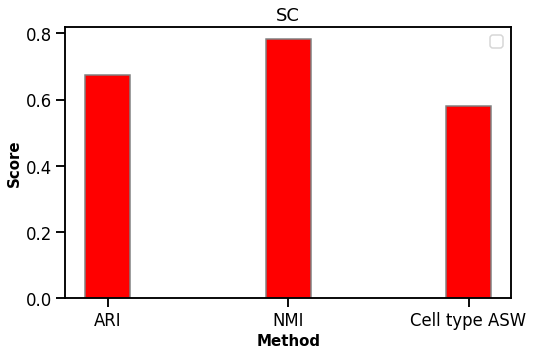

In [25]:
set_seed(seed)
sc.tl.leiden(adata_ref)

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(8, 5))

#a. Adjusted Rand Index
aris_sc = scib.me.ari(adata_ref, cluster_key="leiden", label_key="celltype")

#b. Normalized mutual information
nmis_sc = scib.me.nmi(adata_ref, cluster_key="leiden", label_key="celltype")

#c. Average silhouette width (ASW)
asw_sc = scib.me.silhouette(adata_ref, label_key="celltype", embed="X_pca")

# Make the plot
plt.bar(["ARI", "NMI", "Cell type ASW"], [aris_sc, nmis_sc, asw_sc], color ='r', width = barWidth,
        edgecolor ='grey')

# Adding Xticks
plt.xlabel('Method', fontweight ='bold', fontsize = 15)
plt.ylabel('Score', fontweight ='bold', fontsize = 15)
plt.title('SC')

plt.legend()
plt.show()

In [26]:
np.intersect1d(adata_ref.var.index, adata_vis.var.index).shape

(8729,)